# Test MCMC Retrieval

This notebook performs and analyzes two test run of the MCMC retrievals. This is to ensure that the retrieval
is tractable and that the chosen parameters are sound.

The MCMC simulation itself is performed on the atmospheric state described by the profiles of temperature and water vapor concentrations. However, the actual retrieval quantity is the column water vapor which is computed by integrating the water vapor profile.

## Retrieval Setup

In [1]:
%load_ext autoreload
%autoreload 2

from typhon.arts.workspace import Workspace
import atms
import numpy as np
%matplotlib inline
from matplotlib_settings import *

ws = Workspace()
channels = [0,15,16,17,19]

Loading ARTS API from: /home/simonpf/build/arts/src/libarts_api.so


In [2]:
atms.setup_atmosphere(ws)
atms.setup_sensor(ws, channels)
atms.checks(ws)

ARTS[55973232]: Executing /home/simonpf/src/arts/controlfiles/general/general.arts
ARTS[55973232]: {
ARTS[55973232]: - verbosityInit
ARTS[55973232]: - scat_speciesSet
ARTS[55973232]: - MatrixSet
ARTS[55973232]: - Tensor4SetConstant
ARTS[55973232]: - ArrayOfStringSet
ARTS[55973232]: - Touch
ARTS[55973232]: - FlagOff
ARTS[55973232]: - MatrixSet
ARTS[55973232]: - NumericSet
ARTS[55973232]: - ArrayOfStringSet
ARTS[55973232]: - Tensor3SetConstant
ARTS[55973232]: - Tensor3SetConstant
ARTS[55973232]: - Tensor3SetConstant
ARTS[55973232]: - Tensor3SetConstant
ARTS[55973232]: - Tensor3SetConstant
ARTS[55973232]: - Tensor3SetConstant
ARTS[55973232]: - IndexSet
ARTS[55973232]: - IndexSet
ARTS[55973232]: - IndexSet
ARTS[55973232]: - IndexSet
ARTS[55973232]: - FlagOff
ARTS[55973232]: - output_file_formatSetAscii
ARTS[55973232]: - StringSet
ARTS[55973232]: - IndexSet
ARTS[55973232]: - abs_lineshapeDefine
ARTS[55973232]: - NumericSet
ARTS[55973232]: - NumericSet
ARTS[55973232]: - AgendaSet
ARTS[559732

## A Priori State

Load the mean and covariance matrix from the fitted joint distribution of temperature and water vapor profiles.

In [10]:
qt_mean = np.load("data/qt_mean.npy").ravel()
qt_cov    = np.load("data/qt_cov.npy")
qt_cov_inv  = np.linalg.inv(qt_cov)

## Jumping Function

The jumping functions are used inside the MCMC iteration and propose new atmospheric states for specific humidity, temperature and ozone, respectively. The proposed states are generated from random walks that use scaled versions of the a priori covariances.

In [13]:
import numpy as np
from typhon.retrieval.mcmc import RandomWalk
c = (2.4 / np.sqrt(qt_mean.size)) ** 2
rw_qt  = RandomWalk(c2 * qt_cov)

def j_qt(ws, x, revert = False):
    if revert:
        x_new = x
    else:
        x_new = rw_qt.step(x)
    q_new = (np.exp(x_new[14::-1]).reshape((15,)))
    q_new = atms.mmr2vmr(ws, q_new, "h2o")
    ws.vmr_field.value[0, :, 0, 0] = q_new
    ws.t_field.value[:, 0, 0] = x_new[:14:-1]
    ws.sst = np.maximum(ws.t_field.value[0, 0, 0], 270.0)
    return x_new

## A Priori Distributions

These functions return the likelihood (up to an additive constant) of a given state for each of the variables. 

In [14]:
def p_a_qt(x):
    dx = x - qt_mean
    l = - 0.5 * np.dot(dx, np.dot(qt_cov_inv, dx))
    return l

## Measurement Uncertainty

We assume that uncertainty of the measured brightness temperatures can be described by independent Gaussian error with a standard deviation of $1 K$.

In [15]:
covmat_y = np.diag(np.ones(len(channels)))
covmat_y_inv = np.linalg.inv(covmat_y)

def p_y(y, yf):
    dy = y - yf
    l  = - 0.5 * np.dot(dy, np.dot(covmat_y_inv, dy))
    return l

# Running MCMC


## The Simulated Measurement

For the simulated measurement, we sample a state from the a priori distribution of atmsopheric states and simulate the measured brightness temperatures.

In [119]:
dist = atms.StateDistribution()

# Generate True State
dist.sample(ws)
ws.yCalc()
y_true   = np.copy(ws.y)
q_true  = np.copy(ws.vmr_field.value[0, :, 0, 0].ravel())
t_true  = np.copy(ws.t_field.value[:, 0, 0].ravel())
cwv_true = atms.vmr2cd(ws)
dist.a_priori(ws)

(array([  8.08473991e-03,   7.30145914e-03,   6.01676248e-03,
          4.48967953e-03,   3.32909369e-03,   2.45489321e-03,
          1.77163901e-03,   1.23154249e-03,   8.02342017e-04,
          4.88068856e-04,   2.76837503e-04,   1.32285440e-04,
          4.33038442e-05,   1.08086169e-05,   4.57943111e-06]),
 array([ 285.48313716,  282.26411885,  279.57321176,  276.83634657,
         273.48070648,  269.53279608,  264.97329736,  259.74107238,
         253.68444238,  246.56801493,  238.29440154,  229.51450076,
         221.68151883,  216.90220186,  211.72859046]))

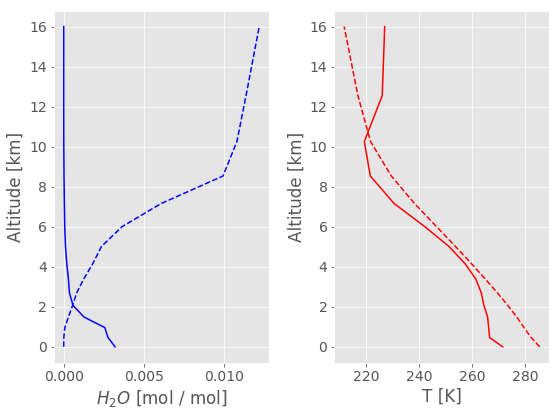

In [120]:
fig, axs = plt.subplots(1,2)
axs[0].plot(q_true,
            ws.z_field.value.ravel() * 1e-3,
            c = 'b')
axs[0].plot(q_mean.ravel()[::-1],
            ws.z_field.value.ravel() * 1e-3,
            c = 'b', ls = '--')
axs[0].set_xlabel("$H_2O$ [mol / mol]")
axs[0].set_ylabel("Altitude [km]")
axs[1].plot(t_true,
            ws.z_field.value.ravel() * 1e-3,
            c = 'r')
axs[1].plot(t_mean.ravel()[::-1],
            ws.z_field.value.ravel() * 1e-3,
            c = 'r', ls = '--')
axs[1].set_xlabel("T [K]")
axs[1].set_ylabel("Altitude [km]")

plt.tight_layout()

### Adapting the Proposal Distribution

A simple heuristic is applied to ensure that reasonable acceptance rates are obtained during the MCMC simulations. After the initial burn-in phase, a number of adjustment runs are performed. If the acceptance rates during these simulation are too low/high that covariance matrices of the corresponding random walks are scaled by a factor 0.7 / 1.5, respectively.

In [121]:
def adapt_covariances(acceptances):
    if (np.sum(a[:, 0]) / a.shape[0]) < 0.2:
        rw_qt.covmat *= 0.7
    if (np.sum(a[:, 0]) / a.shape[0]) > 0.4:
        rw_qt.covmat *= 1.5 

## A First Test Run

A first test run is performed and all simulation steps are saved and plotted. This is to ensure that the different simulation phases are consistent and a reasonable estimate of the true integrated column water vapor is obtained.

In [122]:
from typhon.retrieval.mcmc import MCMC
from atms import vmr2cd

n_burn_in = 1000
n_prod    = 5000
drop      = 20

q = np.zeros(q_mean.size)
t = np.zeros(t_mean.size)
qt = np.zeros(qt_mean.size)

# Add Noise
y_true += np.random.randn(*y_true.shape)

mcmc  = MCMC([[qt, p_a_qt, j_qt]], y_true, p_y, [vmr2cd])

qt_0 = dist.sample_factors()
h1, s1, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
h2, s2, _, a = mcmc.run(ws, 100)
adapt_covariances(a)
h2, s2, _, a = mcmc.run(ws, 100)
adapt_covariances(a)
h2, s2, _, a = mcmc.run(ws, 100)
adapt_covariances(a)
h2, s2, _, a = mcmc.run(ws, 100)
adapt_covariances(a)
h3, s3, _, a = mcmc.run(ws, n_burn_in)
h4, s4, _, a = mcmc.run(ws, n_prod)

MCMC Step 0: ar = 0.0
MCMC Step 10: ar = [ 0.6]
MCMC Step 20: ar = [ 0.55]
MCMC Step 30: ar = [ 0.56666667]
MCMC Step 40: ar = [ 0.575]
MCMC Step 50: ar = [ 0.58]
MCMC Step 60: ar = [ 0.56666667]
MCMC Step 70: ar = [ 0.57142857]
MCMC Step 80: ar = [ 0.575]
MCMC Step 90: ar = [ 0.55555556]
MCMC Step 100: ar = [ 0.56]
MCMC Step 110: ar = [ 0.56363636]
MCMC Step 120: ar = [ 0.55]
MCMC Step 130: ar = [ 0.53846154]
MCMC Step 140: ar = [ 0.53571429]
MCMC Step 150: ar = [ 0.54]
MCMC Step 160: ar = [ 0.55]
MCMC Step 170: ar = [ 0.54117647]
MCMC Step 180: ar = [ 0.53333333]
MCMC Step 190: ar = [ 0.53157895]
MCMC Step 200: ar = [ 0.525]
MCMC Step 210: ar = [ 0.51904762]
MCMC Step 220: ar = [ 0.50909091]
MCMC Step 230: ar = [ 0.50869565]
MCMC Step 240: ar = [ 0.50416667]
MCMC Step 250: ar = [ 0.508]
MCMC Step 260: ar = [ 0.49615385]
MCMC Step 270: ar = [ 0.5]
MCMC Step 280: ar = [ 0.49285714]
MCMC Step 290: ar = [ 0.49310345]
MCMC Step 300: ar = [ 0.5]
MCMC Step 310: ar = [ 0.49677419]
MCMC Step 

MCMC Step 250: ar = [ 0.268]
MCMC Step 260: ar = [ 0.28076923]
MCMC Step 270: ar = [ 0.28888889]
MCMC Step 280: ar = [ 0.28928571]
MCMC Step 290: ar = [ 0.28965517]
MCMC Step 300: ar = [ 0.29666667]
MCMC Step 310: ar = [ 0.3]
MCMC Step 320: ar = [ 0.309375]
MCMC Step 330: ar = [ 0.30909091]
MCMC Step 340: ar = [ 0.30882353]
MCMC Step 350: ar = [ 0.30857143]
MCMC Step 360: ar = [ 0.30833333]
MCMC Step 370: ar = [ 0.30810811]
MCMC Step 380: ar = [ 0.30263158]
MCMC Step 390: ar = [ 0.3]
MCMC Step 400: ar = [ 0.295]
MCMC Step 410: ar = [ 0.29756098]
MCMC Step 420: ar = [ 0.30238095]
MCMC Step 430: ar = [ 0.3]
MCMC Step 440: ar = [ 0.3]
MCMC Step 450: ar = [ 0.30222222]
MCMC Step 460: ar = [ 0.3]
MCMC Step 470: ar = [ 0.29574468]
MCMC Step 480: ar = [ 0.29166667]
MCMC Step 490: ar = [ 0.28979592]
MCMC Step 500: ar = [ 0.29]
MCMC Step 510: ar = [ 0.28823529]
MCMC Step 520: ar = [ 0.28653846]
MCMC Step 530: ar = [ 0.29056604]
MCMC Step 540: ar = [ 0.28888889]
MCMC Step 550: ar = [ 0.28909091]

MCMC Step 2670: ar = [ 0.29475655]
MCMC Step 2680: ar = [ 0.29514925]
MCMC Step 2690: ar = [ 0.29516729]
MCMC Step 2700: ar = [ 0.29592593]
MCMC Step 2710: ar = [ 0.29557196]
MCMC Step 2720: ar = [ 0.29632353]
MCMC Step 2730: ar = [ 0.2967033]
MCMC Step 2740: ar = [ 0.29671533]
MCMC Step 2750: ar = [ 0.29636364]
MCMC Step 2760: ar = [ 0.29673913]
MCMC Step 2770: ar = [ 0.29783394]
MCMC Step 2780: ar = [ 0.29784173]
MCMC Step 2790: ar = [ 0.29784946]
MCMC Step 2800: ar = [ 0.29785714]
MCMC Step 2810: ar = [ 0.29786477]
MCMC Step 2820: ar = [ 0.29893617]
MCMC Step 2830: ar = [ 0.29858657]
MCMC Step 2840: ar = [ 0.29788732]
MCMC Step 2850: ar = [ 0.29859649]
MCMC Step 2860: ar = [ 0.2986014]
MCMC Step 2870: ar = [ 0.3]
MCMC Step 2880: ar = [ 0.3]
MCMC Step 2890: ar = [ 0.30034602]
MCMC Step 2900: ar = [ 0.29931034]
MCMC Step 2910: ar = [ 0.29896907]
MCMC Step 2920: ar = [ 0.29931507]
MCMC Step 2930: ar = [ 0.29863481]
MCMC Step 2940: ar = [ 0.29863946]
MCMC Step 2950: ar = [ 0.29830508]
M

#### Column Water Vapor

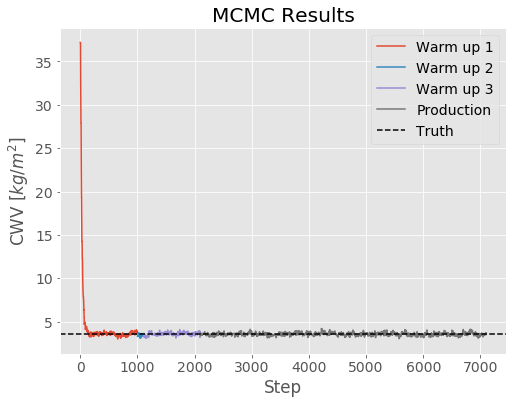

In [123]:
plt.figure()
plt.plot(np.arange(0, 1001), s1, label = 'Warm up 1')
plt.plot(np.arange(0, 100) + 1001, s2, label = 'Warm up 2')
plt.plot(np.arange(0, 1000) + 1101, s3, label = 'Warm up 3')
plt.plot(np.arange(0, 5000) + 2101, s4, label = 'Production')
plt.axhline(cwv_true, c = 'k', ls = '--', label = 'Truth')

plt.legend()
plt.xlabel("Step")
plt.ylabel("CWV [$kg / m^2$]")
plt.title("MCMC Results")

#### Water Vapor and Temperature Profiles

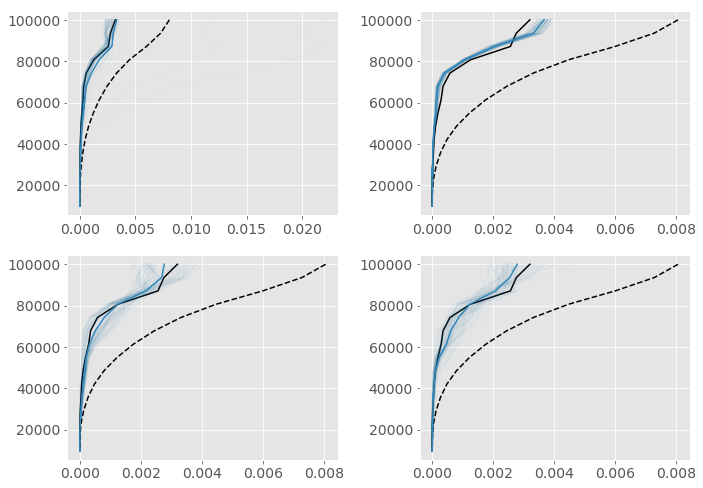

In [127]:
profiles_q = [np.exp(h1[0][:,:15]), np.exp(h2[0][:,:15]), np.exp(h3[0][:,:15]), np.exp(h4[0][:,:15])]
profiles_t = [h1[0][:, 15:], h2[0][:, 15:], h3[0][:, 15:], h4[0][:, 15:]]

f, axs = plt.subplots(2, 2, figsize = (10, 7))
axs = axs.ravel()
for i in range(4):
    axs[i].plot(np.exp(dist.q_log_mean)[::-1] * 28.9 / 18.0,
                ws.p_grid, c = 'k', ls = '--')
    axs[i].plot(q_true, ws.p_grid, c = 'k')
    axs[i].plot(np.mean(profiles_q[i], axis = 0)[::-1] * 28.9 / 18.0,
             ws.p_grid,
             c = 'C1')
    for j in range(100):
        k = np.random.randint(0, profiles_q[i].shape[0])
        axs[i].plot(profiles_q[i][k, ::-1] * 28.9 / 18.0,
                 ws.p_grid,
                 c = 'C1',
                 alpha = 0.02)
plt.tight_layout()

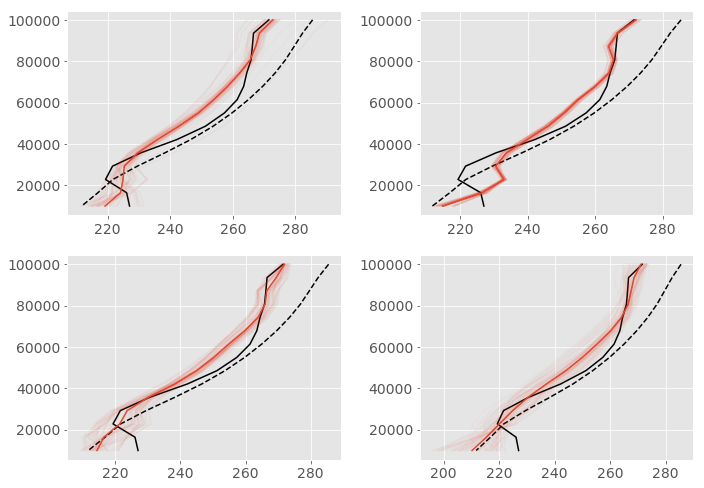

In [126]:
f, axs = plt.subplots(2, 2, figsize = (10, 7))
axs = axs.ravel()
for i in range(4):
    axs[i].plot(dist.t_mean[::-1],
                ws.p_grid, c = 'k', ls = '--')
    axs[i].plot(t_true, ws.p_grid, c = 'k')
    axs[i].plot(np.mean(profiles_t[i], axis = 0)[::-1],
             ws.p_grid,
             c = 'C0')
    for j in range(100):
        k = np.random.randint(0, profiles_t[i].shape[0])
        axs[i].plot(profiles_t[i][k, ::-1],
                     ws.p_grid,
                     c = "C0",
                     alpha = 0.02)
        
plt.tight_layout()

## A Complete Production Run

For the generation of the probabilistic test data, each MCMC production run consists of eight MCMC simulations with different starting points. The starting points are sampled from the a priori distribution of atmospheric states.

Each simulation consists of a warm-up phase, followed by 5 short adaption phases, where the covariance matrix of the random walked used for the proposal of new states is adapted. After that follows an additional burn in phase with the previously adapted random walk proposal distribution. 

The warm-up phase is then followed by a production phase of 5000 steps.

In [136]:
from typhon.retrieval.mcmc import MCMC
from atms import vmr2cd

n_burn_in = 500
n_prod    = 5000
drop      = 10
def run_retrieval(i):
    
    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c2 * qt_cov)

    # Generate True State
    dist.sample(ws)
    ws.yCalc()
    y_true   = np.copy(ws.y)
    q_true  = np.copy(ws.vmr_field.value[0, :, 0, 0].ravel())
    t_true  = np.copy(ws.t_field.value[:, 0, 0].ravel())
    cwv_true = atms.vmr2cd(ws)
    
    dist.a_priori(ws)
    q = np.zeros(q_mean.size)
    t = np.zeros(t_mean.size)
    qt = np.zeros(qt_mean.size)

    # Add Noise
    y_true += np.random.randn(*y_true.shape)
    
    #try:
    mcmc  = MCMC([[qt, p_a_qt, j_qt]], y_true, p_y, [vmr2cd])

    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_1, s_1, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c2 * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_2, s_2, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c2 * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_3, s_3, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c2 * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_4, s_4, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c2 * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_5, s_5, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c2 * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_6, s_6, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c2 * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_7, s_7, _, _ = mcmc.run(ws, n_prod)

    # Reset covariance matrices.
    rw_qt.covmat = np.copy(c2 * qt_cov)
    qt_0 = dist.sample_factors()
    _, _, _, a = mcmc.warm_up(ws, [qt_0], n_burn_in)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, 200)
    adapt_covariances(a)
    _, _, _, a = mcmc.run(ws, n_burn_in)
    hist_8, s_8, _, _ = mcmc.run(ws, n_prod)

    profiles_q =  np.stack([hist_1[0][::drop, :15],
                            hist_2[0][::drop, :15],
                            hist_3[0][::drop, :15],
                            hist_4[0][::drop, :15],
                            hist_5[0][::drop, :15],
                            hist_6[0][::drop, :15],
                            hist_7[0][::drop, :15],
                            hist_8[0][::drop, :15]])
    profiles_t =  np.stack([hist_1[0][::drop, 15:],
                            hist_2[0][::drop, 15:],
                            hist_3[0][::drop, 15:],
                            hist_4[0][::drop, 15:],
                            hist_5[0][::drop, 15:],
                            hist_6[0][::drop, 15:],
                            hist_7[0][::drop, 15:],
                            hist_8[0][::drop, 15:]])
    cwv = np.stack([s_1[::drop], s_2[::drop], s_3[::drop], s_4[::drop],
                    s_5[::drop],s_6[::drop],s_7[::drop],s_8[::drop]], axis=0)
    return y_true, q_true, cwv_true, profiles_q, profiles_t, cwv

The `run_retrieval` function takes a dummy index argument, which is however required to use asynchronous map to distribute the retrievals. For now, only one test retrieval is performed.

In [137]:
y_true, q_true, cwv_true, profiles_q, profiles_t, cwv = run_retrieval(0)

MCMC Step 0: ar = 0.0
MCMC Step 10: ar = [ 0.6]
MCMC Step 20: ar = [ 0.3]
MCMC Step 30: ar = [ 0.26666667]
MCMC Step 40: ar = [ 0.2]
MCMC Step 50: ar = [ 0.16]
MCMC Step 60: ar = [ 0.16666667]
MCMC Step 70: ar = [ 0.14285714]
MCMC Step 80: ar = [ 0.1375]
MCMC Step 90: ar = [ 0.12222222]
MCMC Step 100: ar = [ 0.12]
MCMC Step 110: ar = [ 0.11818182]
MCMC Step 120: ar = [ 0.11666667]
MCMC Step 130: ar = [ 0.12307692]
MCMC Step 140: ar = [ 0.13571429]
MCMC Step 150: ar = [ 0.12666667]
MCMC Step 160: ar = [ 0.125]
MCMC Step 170: ar = [ 0.12941176]
MCMC Step 180: ar = [ 0.12222222]
MCMC Step 190: ar = [ 0.12105263]
MCMC Step 200: ar = [ 0.12]
MCMC Step 210: ar = [ 0.11904762]
MCMC Step 220: ar = [ 0.11363636]
MCMC Step 230: ar = [ 0.11304348]
MCMC Step 240: ar = [ 0.1125]
MCMC Step 250: ar = [ 0.116]
MCMC Step 260: ar = [ 0.11923077]
MCMC Step 270: ar = [ 0.12222222]
MCMC Step 280: ar = [ 0.11785714]
MCMC Step 290: ar = [ 0.1137931]
MCMC Step 300: ar = [ 0.11333333]
MCMC Step 310: ar = [ 0.1

MCMC Step 610: ar = [ 0.07704918]
MCMC Step 620: ar = [ 0.07741935]
MCMC Step 630: ar = [ 0.07619048]
MCMC Step 640: ar = [ 0.0765625]
MCMC Step 650: ar = [ 0.07538462]
MCMC Step 660: ar = [ 0.07424242]
MCMC Step 670: ar = [ 0.07313433]
MCMC Step 680: ar = [ 0.07205882]
MCMC Step 690: ar = [ 0.07101449]
MCMC Step 700: ar = [ 0.07142857]
MCMC Step 710: ar = [ 0.07323944]
MCMC Step 720: ar = [ 0.07222222]
MCMC Step 730: ar = [ 0.07260274]
MCMC Step 740: ar = [ 0.07162162]
MCMC Step 750: ar = [ 0.07066667]
MCMC Step 760: ar = [ 0.06973684]
MCMC Step 770: ar = [ 0.06883117]
MCMC Step 780: ar = [ 0.06794872]
MCMC Step 790: ar = [ 0.06708861]
MCMC Step 800: ar = [ 0.06625]
MCMC Step 810: ar = [ 0.0654321]
MCMC Step 820: ar = [ 0.06463415]
MCMC Step 830: ar = [ 0.06385542]
MCMC Step 840: ar = [ 0.06428571]
MCMC Step 850: ar = [ 0.06470588]
MCMC Step 860: ar = [ 0.06395349]
MCMC Step 870: ar = [ 0.06436782]
MCMC Step 880: ar = [ 0.06477273]
MCMC Step 890: ar = [ 0.06404494]
MCMC Step 900: ar =

MCMC Step 3000: ar = [ 0.06133333]
MCMC Step 3010: ar = [ 0.06112957]
MCMC Step 3020: ar = [ 0.06125828]
MCMC Step 3030: ar = [ 0.06138614]
MCMC Step 3040: ar = [ 0.06151316]
MCMC Step 3050: ar = [ 0.06163934]
MCMC Step 3060: ar = [ 0.06143791]
MCMC Step 3070: ar = [ 0.06123779]
MCMC Step 3080: ar = [ 0.06103896]
MCMC Step 3090: ar = [ 0.06116505]
MCMC Step 3100: ar = [ 0.06096774]
MCMC Step 3110: ar = [ 0.0607717]
MCMC Step 3120: ar = [ 0.06057692]
MCMC Step 3130: ar = [ 0.06038339]
MCMC Step 3140: ar = [ 0.06019108]
MCMC Step 3150: ar = [ 0.06]
MCMC Step 3160: ar = [ 0.06012658]
MCMC Step 3170: ar = [ 0.05993691]
MCMC Step 3180: ar = [ 0.05974843]
MCMC Step 3190: ar = [ 0.05987461]
MCMC Step 3200: ar = [ 0.0596875]
MCMC Step 3210: ar = [ 0.05950156]
MCMC Step 3220: ar = [ 0.05962733]
MCMC Step 3230: ar = [ 0.05975232]
MCMC Step 3240: ar = [ 0.0595679]
MCMC Step 3250: ar = [ 0.05969231]
MCMC Step 3260: ar = [ 0.0601227]
MCMC Step 3270: ar = [ 0.05993884]
MCMC Step 3280: ar = [ 0.05975

MCMC Step 400: ar = [ 0.0675]
MCMC Step 410: ar = [ 0.06585366]
MCMC Step 420: ar = [ 0.06428571]
MCMC Step 430: ar = [ 0.0627907]
MCMC Step 440: ar = [ 0.06363636]
MCMC Step 450: ar = [ 0.06666667]
MCMC Step 460: ar = [ 0.06521739]
MCMC Step 470: ar = [ 0.06595745]
MCMC Step 480: ar = [ 0.06458333]
MCMC Step 490: ar = [ 0.06326531]
MCMC Step 0: ar = 0.0
MCMC Step 10: ar = [ 0.2]
MCMC Step 20: ar = [ 0.2]
MCMC Step 30: ar = [ 0.16666667]
MCMC Step 40: ar = [ 0.15]
MCMC Step 50: ar = [ 0.12]
MCMC Step 60: ar = [ 0.13333333]
MCMC Step 70: ar = [ 0.11428571]
MCMC Step 80: ar = [ 0.1125]
MCMC Step 90: ar = [ 0.1]
MCMC Step 100: ar = [ 0.1]
MCMC Step 110: ar = [ 0.09090909]
MCMC Step 120: ar = [ 0.09166667]
MCMC Step 130: ar = [ 0.1]
MCMC Step 140: ar = [ 0.1]
MCMC Step 150: ar = [ 0.09333333]
MCMC Step 160: ar = [ 0.09375]
MCMC Step 170: ar = [ 0.09411765]
MCMC Step 180: ar = [ 0.1]
MCMC Step 190: ar = [ 0.09473684]
MCMC Step 0: ar = 0.0
MCMC Step 10: ar = [ 0.]
MCMC Step 20: ar = [ 0.]
MC

MCMC Step 1010: ar = [ 0.05544554]
MCMC Step 1020: ar = [ 0.05490196]
MCMC Step 1030: ar = [ 0.05533981]
MCMC Step 1040: ar = [ 0.05576923]
MCMC Step 1050: ar = [ 0.0552381]
MCMC Step 1060: ar = [ 0.05566038]
MCMC Step 1070: ar = [ 0.05514019]
MCMC Step 1080: ar = [ 0.05555556]
MCMC Step 1090: ar = [ 0.05688073]
MCMC Step 1100: ar = [ 0.05818182]
MCMC Step 1110: ar = [ 0.05765766]
MCMC Step 1120: ar = [ 0.05714286]
MCMC Step 1130: ar = [ 0.05663717]
MCMC Step 1140: ar = [ 0.05614035]
MCMC Step 1150: ar = [ 0.05652174]
MCMC Step 1160: ar = [ 0.05603448]
MCMC Step 1170: ar = [ 0.05641026]
MCMC Step 1180: ar = [ 0.05677966]
MCMC Step 1190: ar = [ 0.05882353]
MCMC Step 1200: ar = [ 0.06]
MCMC Step 1210: ar = [ 0.06033058]
MCMC Step 1220: ar = [ 0.06065574]
MCMC Step 1230: ar = [ 0.06178862]
MCMC Step 1240: ar = [ 0.06209677]
MCMC Step 1250: ar = [ 0.0616]
MCMC Step 1260: ar = [ 0.06190476]
MCMC Step 1270: ar = [ 0.06141732]
MCMC Step 1280: ar = [ 0.06171875]
MCMC Step 1290: ar = [ 0.062015

MCMC Step 3380: ar = [ 0.05710059]
MCMC Step 3390: ar = [ 0.05693215]
MCMC Step 3400: ar = [ 0.05705882]
MCMC Step 3410: ar = [ 0.0568915]
MCMC Step 3420: ar = [ 0.05672515]
MCMC Step 3430: ar = [ 0.05685131]
MCMC Step 3440: ar = [ 0.05668605]
MCMC Step 3450: ar = [ 0.05652174]
MCMC Step 3460: ar = [ 0.0566474]
MCMC Step 3470: ar = [ 0.05648415]
MCMC Step 3480: ar = [ 0.0566092]
MCMC Step 3490: ar = [ 0.05673352]
MCMC Step 3500: ar = [ 0.05657143]
MCMC Step 3510: ar = [ 0.05641026]
MCMC Step 3520: ar = [ 0.05625]
MCMC Step 3530: ar = [ 0.05637394]
MCMC Step 3540: ar = [ 0.05649718]
MCMC Step 3550: ar = [ 0.05633803]
MCMC Step 3560: ar = [ 0.05646067]
MCMC Step 3570: ar = [ 0.05630252]
MCMC Step 3580: ar = [ 0.05614525]
MCMC Step 3590: ar = [ 0.05598886]
MCMC Step 3600: ar = [ 0.05583333]
MCMC Step 3610: ar = [ 0.05623269]
MCMC Step 3620: ar = [ 0.05635359]
MCMC Step 3630: ar = [ 0.05619835]
MCMC Step 3640: ar = [ 0.05604396]
MCMC Step 3650: ar = [ 0.05589041]
MCMC Step 3660: ar = [ 0.0

MCMC Step 120: ar = [ 0.04166667]
MCMC Step 130: ar = [ 0.03846154]
MCMC Step 140: ar = [ 0.03571429]
MCMC Step 150: ar = [ 0.03333333]
MCMC Step 160: ar = [ 0.03125]
MCMC Step 170: ar = [ 0.02941176]
MCMC Step 180: ar = [ 0.02777778]
MCMC Step 190: ar = [ 0.02631579]
MCMC Step 0: ar = 0.0
MCMC Step 10: ar = [ 0.1]
MCMC Step 20: ar = [ 0.1]
MCMC Step 30: ar = [ 0.1]
MCMC Step 40: ar = [ 0.15]
MCMC Step 50: ar = [ 0.14]
MCMC Step 60: ar = [ 0.11666667]
MCMC Step 70: ar = [ 0.11428571]
MCMC Step 80: ar = [ 0.1125]
MCMC Step 90: ar = [ 0.1]
MCMC Step 100: ar = [ 0.1]
MCMC Step 110: ar = [ 0.1]
MCMC Step 120: ar = [ 0.09166667]
MCMC Step 130: ar = [ 0.08461538]
MCMC Step 140: ar = [ 0.09285714]
MCMC Step 150: ar = [ 0.08666667]
MCMC Step 160: ar = [ 0.0875]
MCMC Step 170: ar = [ 0.1]
MCMC Step 180: ar = [ 0.1]
MCMC Step 190: ar = [ 0.09473684]
MCMC Step 0: ar = 0.0
MCMC Step 10: ar = [ 0.]
MCMC Step 20: ar = [ 0.]
MCMC Step 30: ar = [ 0.]
MCMC Step 40: ar = [ 0.]
MCMC Step 50: ar = [ 0.02]

MCMC Step 1380: ar = [ 0.05]
MCMC Step 1390: ar = [ 0.04964029]
MCMC Step 1400: ar = [ 0.04928571]
MCMC Step 1410: ar = [ 0.05035461]
MCMC Step 1420: ar = [ 0.05]
MCMC Step 1430: ar = [ 0.04965035]
MCMC Step 1440: ar = [ 0.04930556]
MCMC Step 1450: ar = [ 0.04965517]
MCMC Step 1460: ar = [ 0.04931507]
MCMC Step 1470: ar = [ 0.04897959]
MCMC Step 1480: ar = [ 0.04864865]
MCMC Step 1490: ar = [ 0.04899329]
MCMC Step 1500: ar = [ 0.04866667]
MCMC Step 1510: ar = [ 0.04834437]
MCMC Step 1520: ar = [ 0.04868421]
MCMC Step 1530: ar = [ 0.04836601]
MCMC Step 1540: ar = [ 0.0487013]
MCMC Step 1550: ar = [ 0.0483871]
MCMC Step 1560: ar = [ 0.04807692]
MCMC Step 1570: ar = [ 0.0477707]
MCMC Step 1580: ar = [ 0.04873418]
MCMC Step 1590: ar = [ 0.0490566]
MCMC Step 1600: ar = [ 0.04875]
MCMC Step 1610: ar = [ 0.04906832]
MCMC Step 1620: ar = [ 0.04876543]
MCMC Step 1630: ar = [ 0.04846626]
MCMC Step 1640: ar = [ 0.04939024]
MCMC Step 1650: ar = [ 0.05030303]
MCMC Step 1660: ar = [ 0.05060241]
MCMC

MCMC Step 3750: ar = [ 0.06213333]
MCMC Step 3760: ar = [ 0.06196809]
MCMC Step 3770: ar = [ 0.06206897]
MCMC Step 3780: ar = [ 0.06216931]
MCMC Step 3790: ar = [ 0.06226913]
MCMC Step 3800: ar = [ 0.06210526]
MCMC Step 3810: ar = [ 0.06194226]
MCMC Step 3820: ar = [ 0.06204188]
MCMC Step 3830: ar = [ 0.06214099]
MCMC Step 3840: ar = [ 0.06197917]
MCMC Step 3850: ar = [ 0.06181818]
MCMC Step 3860: ar = [ 0.0619171]
MCMC Step 3870: ar = [ 0.06175711]
MCMC Step 3880: ar = [ 0.06159794]
MCMC Step 3890: ar = [ 0.06169666]
MCMC Step 3900: ar = [ 0.06179487]
MCMC Step 3910: ar = [ 0.06214834]
MCMC Step 3920: ar = [ 0.0622449]
MCMC Step 3930: ar = [ 0.06208651]
MCMC Step 3940: ar = [ 0.06218274]
MCMC Step 3950: ar = [ 0.06227848]
MCMC Step 3960: ar = [ 0.06237374]
MCMC Step 3970: ar = [ 0.06221662]
MCMC Step 3980: ar = [ 0.0620603]
MCMC Step 3990: ar = [ 0.06240602]
MCMC Step 4000: ar = [ 0.06225]
MCMC Step 4010: ar = [ 0.06234414]
MCMC Step 4020: ar = [ 0.06243781]
MCMC Step 4030: ar = [ 0.0

MCMC Step 160: ar = [ 0.0625]
MCMC Step 170: ar = [ 0.06470588]
MCMC Step 180: ar = [ 0.06111111]
MCMC Step 190: ar = [ 0.06315789]
MCMC Step 0: ar = 0.0
MCMC Step 10: ar = [ 0.]
MCMC Step 20: ar = [ 0.]
MCMC Step 30: ar = [ 0.]
MCMC Step 40: ar = [ 0.025]
MCMC Step 50: ar = [ 0.02]
MCMC Step 60: ar = [ 0.01666667]
MCMC Step 70: ar = [ 0.01428571]
MCMC Step 80: ar = [ 0.0125]
MCMC Step 90: ar = [ 0.01111111]
MCMC Step 100: ar = [ 0.01]
MCMC Step 110: ar = [ 0.00909091]
MCMC Step 120: ar = [ 0.00833333]
MCMC Step 130: ar = [ 0.00769231]
MCMC Step 140: ar = [ 0.01428571]
MCMC Step 150: ar = [ 0.02]
MCMC Step 160: ar = [ 0.01875]
MCMC Step 170: ar = [ 0.01764706]
MCMC Step 180: ar = [ 0.02222222]
MCMC Step 190: ar = [ 0.02631579]
MCMC Step 0: ar = 0.0
MCMC Step 10: ar = [ 0.1]
MCMC Step 20: ar = [ 0.05]
MCMC Step 30: ar = [ 0.03333333]
MCMC Step 40: ar = [ 0.025]
MCMC Step 50: ar = [ 0.06]
MCMC Step 60: ar = [ 0.05]
MCMC Step 70: ar = [ 0.04285714]
MCMC Step 80: ar = [ 0.0375]
MCMC Step 9

MCMC Step 1760: ar = [ 0.05625]
MCMC Step 1770: ar = [ 0.05762712]
MCMC Step 1780: ar = [ 0.05842697]
MCMC Step 1790: ar = [ 0.05921788]
MCMC Step 1800: ar = [ 0.05944444]
MCMC Step 1810: ar = [ 0.05966851]
MCMC Step 1820: ar = [ 0.05934066]
MCMC Step 1830: ar = [ 0.05956284]
MCMC Step 1840: ar = [ 0.05923913]
MCMC Step 1850: ar = [ 0.05945946]
MCMC Step 1860: ar = [ 0.06021505]
MCMC Step 1870: ar = [ 0.06042781]
MCMC Step 1880: ar = [ 0.06117021]
MCMC Step 1890: ar = [ 0.06084656]
MCMC Step 1900: ar = [ 0.06105263]
MCMC Step 1910: ar = [ 0.06073298]
MCMC Step 1920: ar = [ 0.0609375]
MCMC Step 1930: ar = [ 0.06062176]
MCMC Step 1940: ar = [ 0.06082474]
MCMC Step 1950: ar = [ 0.06102564]
MCMC Step 1960: ar = [ 0.06122449]
MCMC Step 1970: ar = [ 0.06142132]
MCMC Step 1980: ar = [ 0.06161616]
MCMC Step 1990: ar = [ 0.06130653]
MCMC Step 2000: ar = [ 0.062]
MCMC Step 2010: ar = [ 0.06169154]
MCMC Step 2020: ar = [ 0.06138614]
MCMC Step 2030: ar = [ 0.06108374]
MCMC Step 2040: ar = [ 0.0607

MCMC Step 4130: ar = [ 0.06440678]
MCMC Step 4140: ar = [ 0.06449275]
MCMC Step 4150: ar = [ 0.06457831]
MCMC Step 4160: ar = [ 0.06466346]
MCMC Step 4170: ar = [ 0.06450839]
MCMC Step 4180: ar = [ 0.06435407]
MCMC Step 4190: ar = [ 0.06420048]
MCMC Step 4200: ar = [ 0.06404762]
MCMC Step 4210: ar = [ 0.06389549]
MCMC Step 4220: ar = [ 0.06398104]
MCMC Step 4230: ar = [ 0.06406619]
MCMC Step 4240: ar = [ 0.06391509]
MCMC Step 4250: ar = [ 0.06376471]
MCMC Step 4260: ar = [ 0.06361502]
MCMC Step 4270: ar = [ 0.06370023]
MCMC Step 4280: ar = [ 0.06378505]
MCMC Step 4290: ar = [ 0.06363636]
MCMC Step 4300: ar = [ 0.06418605]
MCMC Step 4310: ar = [ 0.06426914]
MCMC Step 4320: ar = [ 0.06458333]
MCMC Step 4330: ar = [ 0.06512702]
MCMC Step 4340: ar = [ 0.06497696]
MCMC Step 4350: ar = [ 0.06482759]
MCMC Step 4360: ar = [ 0.06490826]
MCMC Step 4370: ar = [ 0.06521739]
MCMC Step 4380: ar = [ 0.06506849]
MCMC Step 4390: ar = [ 0.06537585]
MCMC Step 4400: ar = [ 0.06590909]
MCMC Step 4410: ar =

MCMC Step 180: ar = [ 0.06666667]
MCMC Step 190: ar = [ 0.06315789]
MCMC Step 200: ar = [ 0.07]
MCMC Step 210: ar = [ 0.07142857]
MCMC Step 220: ar = [ 0.07272727]
MCMC Step 230: ar = [ 0.07391304]
MCMC Step 240: ar = [ 0.07083333]
MCMC Step 250: ar = [ 0.068]
MCMC Step 260: ar = [ 0.06538462]
MCMC Step 270: ar = [ 0.06666667]
MCMC Step 280: ar = [ 0.06785714]
MCMC Step 290: ar = [ 0.07241379]
MCMC Step 300: ar = [ 0.07666667]
MCMC Step 310: ar = [ 0.07741935]
MCMC Step 320: ar = [ 0.078125]
MCMC Step 330: ar = [ 0.07878788]
MCMC Step 340: ar = [ 0.07941176]
MCMC Step 350: ar = [ 0.08]
MCMC Step 360: ar = [ 0.07777778]
MCMC Step 370: ar = [ 0.08378378]
MCMC Step 380: ar = [ 0.08157895]
MCMC Step 390: ar = [ 0.07948718]
MCMC Step 400: ar = [ 0.0775]
MCMC Step 410: ar = [ 0.07804878]
MCMC Step 420: ar = [ 0.07619048]
MCMC Step 430: ar = [ 0.0744186]
MCMC Step 440: ar = [ 0.07272727]
MCMC Step 450: ar = [ 0.07333333]
MCMC Step 460: ar = [ 0.07391304]
MCMC Step 470: ar = [ 0.07234043]
MCMC

MCMC Step 2120: ar = [ 0.06179245]
MCMC Step 2130: ar = [ 0.06150235]
MCMC Step 2140: ar = [ 0.06121495]
MCMC Step 2150: ar = [ 0.06093023]
MCMC Step 2160: ar = [ 0.06064815]
MCMC Step 2170: ar = [ 0.06129032]
MCMC Step 2180: ar = [ 0.06146789]
MCMC Step 2190: ar = [ 0.06118721]
MCMC Step 2200: ar = [ 0.06181818]
MCMC Step 2210: ar = [ 0.06199095]
MCMC Step 2220: ar = [ 0.06171171]
MCMC Step 2230: ar = [ 0.06233184]
MCMC Step 2240: ar = [ 0.06205357]
MCMC Step 2250: ar = [ 0.06177778]
MCMC Step 2260: ar = [ 0.0619469]
MCMC Step 2270: ar = [ 0.06167401]
MCMC Step 2280: ar = [ 0.06140351]
MCMC Step 2290: ar = [ 0.06157205]
MCMC Step 2300: ar = [ 0.06130435]
MCMC Step 2310: ar = [ 0.06190476]
MCMC Step 2320: ar = [ 0.06206897]
MCMC Step 2330: ar = [ 0.06180258]
MCMC Step 2340: ar = [ 0.06196581]
MCMC Step 2350: ar = [ 0.06212766]
MCMC Step 2360: ar = [ 0.06186441]
MCMC Step 2370: ar = [ 0.06244726]
MCMC Step 2380: ar = [ 0.06260504]
MCMC Step 2390: ar = [ 0.0623431]
MCMC Step 2400: ar = [

MCMC Step 4470: ar = [ 0.06644295]
MCMC Step 4480: ar = [ 0.06651786]
MCMC Step 4490: ar = [ 0.06659243]
MCMC Step 4500: ar = [ 0.06666667]
MCMC Step 4510: ar = [ 0.06651885]
MCMC Step 4520: ar = [ 0.06659292]
MCMC Step 4530: ar = [ 0.06666667]
MCMC Step 4540: ar = [ 0.06651982]
MCMC Step 4550: ar = [ 0.06637363]
MCMC Step 4560: ar = [ 0.06644737]
MCMC Step 4570: ar = [ 0.06630197]
MCMC Step 4580: ar = [ 0.06615721]
MCMC Step 4590: ar = [ 0.06623094]
MCMC Step 4600: ar = [ 0.06608696]
MCMC Step 4610: ar = [ 0.0659436]
MCMC Step 4620: ar = [ 0.06580087]
MCMC Step 4630: ar = [ 0.06565875]
MCMC Step 4640: ar = [ 0.06573276]
MCMC Step 4650: ar = [ 0.06580645]
MCMC Step 4660: ar = [ 0.06566524]
MCMC Step 4670: ar = [ 0.06552463]
MCMC Step 4680: ar = [ 0.06581197]
MCMC Step 4690: ar = [ 0.06588486]
MCMC Step 4700: ar = [ 0.06595745]
MCMC Step 4710: ar = [ 0.06602972]
MCMC Step 4720: ar = [ 0.06610169]
MCMC Step 4730: ar = [ 0.06617336]
MCMC Step 4740: ar = [ 0.06603376]
MCMC Step 4750: ar = 

MCMC Step 380: ar = [ 0.08157895]
MCMC Step 390: ar = [ 0.08205128]
MCMC Step 400: ar = [ 0.085]
MCMC Step 410: ar = [ 0.08536585]
MCMC Step 420: ar = [ 0.08333333]
MCMC Step 430: ar = [ 0.08139535]
MCMC Step 440: ar = [ 0.07954545]
MCMC Step 450: ar = [ 0.08]
MCMC Step 460: ar = [ 0.08043478]
MCMC Step 470: ar = [ 0.0787234]
MCMC Step 480: ar = [ 0.08333333]
MCMC Step 490: ar = [ 0.08163265]
MCMC Step 0: ar = 0.0
MCMC Step 10: ar = [ 0.]
MCMC Step 20: ar = [ 0.]
MCMC Step 30: ar = [ 0.03333333]
MCMC Step 40: ar = [ 0.075]
MCMC Step 50: ar = [ 0.06]
MCMC Step 60: ar = [ 0.05]
MCMC Step 70: ar = [ 0.04285714]
MCMC Step 80: ar = [ 0.0375]
MCMC Step 90: ar = [ 0.03333333]
MCMC Step 100: ar = [ 0.03]
MCMC Step 110: ar = [ 0.03636364]
MCMC Step 120: ar = [ 0.03333333]
MCMC Step 130: ar = [ 0.03076923]
MCMC Step 140: ar = [ 0.03571429]
MCMC Step 150: ar = [ 0.04]
MCMC Step 160: ar = [ 0.0375]
MCMC Step 170: ar = [ 0.03529412]
MCMC Step 180: ar = [ 0.03333333]
MCMC Step 190: ar = [ 0.03157895

MCMC Step 2310: ar = [ 0.05974026]
MCMC Step 2320: ar = [ 0.05991379]
MCMC Step 2330: ar = [ 0.06008584]
MCMC Step 2340: ar = [ 0.06025641]
MCMC Step 2350: ar = [ 0.06]
MCMC Step 2360: ar = [ 0.06016949]
MCMC Step 2370: ar = [ 0.06075949]
MCMC Step 2380: ar = [ 0.0605042]
MCMC Step 2390: ar = [ 0.06025105]
MCMC Step 2400: ar = [ 0.06]
MCMC Step 2410: ar = [ 0.05975104]
MCMC Step 2420: ar = [ 0.05950413]
MCMC Step 2430: ar = [ 0.05967078]
MCMC Step 2440: ar = [ 0.05983607]
MCMC Step 2450: ar = [ 0.06]
MCMC Step 2460: ar = [ 0.0597561]
MCMC Step 2470: ar = [ 0.05991903]
MCMC Step 2480: ar = [ 0.0608871]
MCMC Step 2490: ar = [ 0.06064257]
MCMC Step 2500: ar = [ 0.0604]
MCMC Step 2510: ar = [ 0.06015936]
MCMC Step 2520: ar = [ 0.05992063]
MCMC Step 2530: ar = [ 0.05968379]
MCMC Step 2540: ar = [ 0.05944882]
MCMC Step 2550: ar = [ 0.05921569]
MCMC Step 2560: ar = [ 0.05898437]
MCMC Step 2570: ar = [ 0.05875486]
MCMC Step 2580: ar = [ 0.05968992]
MCMC Step 2590: ar = [ 0.06061776]
MCMC Step 

MCMC Step 4680: ar = [ 0.06367521]
MCMC Step 4690: ar = [ 0.06353945]
MCMC Step 4700: ar = [ 0.06340426]
MCMC Step 4710: ar = [ 0.06326964]
MCMC Step 4720: ar = [ 0.06313559]
MCMC Step 4730: ar = [ 0.06300211]
MCMC Step 4740: ar = [ 0.0628692]
MCMC Step 4750: ar = [ 0.06294737]
MCMC Step 4760: ar = [ 0.06281513]
MCMC Step 4770: ar = [ 0.06310273]
MCMC Step 4780: ar = [ 0.06317992]
MCMC Step 4790: ar = [ 0.06304802]
MCMC Step 4800: ar = [ 0.063125]
MCMC Step 4810: ar = [ 0.06299376]
MCMC Step 4820: ar = [ 0.06286307]
MCMC Step 4830: ar = [ 0.063147]
MCMC Step 4840: ar = [ 0.06322314]
MCMC Step 4850: ar = [ 0.06329897]
MCMC Step 4860: ar = [ 0.06316872]
MCMC Step 4870: ar = [ 0.06324435]
MCMC Step 4880: ar = [ 0.06331967]
MCMC Step 4890: ar = [ 0.06339468]
MCMC Step 4900: ar = [ 0.06326531]
MCMC Step 4910: ar = [ 0.06334012]
MCMC Step 4920: ar = [ 0.06321138]
MCMC Step 4930: ar = [ 0.06308316]
MCMC Step 4940: ar = [ 0.06315789]
MCMC Step 4950: ar = [ 0.0630303]
MCMC Step 4960: ar = [ 0.0

MCMC Step 100: ar = [ 0.04]
MCMC Step 110: ar = [ 0.04545455]
MCMC Step 120: ar = [ 0.04166667]
MCMC Step 130: ar = [ 0.04615385]
MCMC Step 140: ar = [ 0.04285714]
MCMC Step 150: ar = [ 0.04]
MCMC Step 160: ar = [ 0.0375]
MCMC Step 170: ar = [ 0.03529412]
MCMC Step 180: ar = [ 0.04444444]
MCMC Step 190: ar = [ 0.05263158]
MCMC Step 200: ar = [ 0.055]
MCMC Step 210: ar = [ 0.05238095]
MCMC Step 220: ar = [ 0.05454545]
MCMC Step 230: ar = [ 0.05217391]
MCMC Step 240: ar = [ 0.05]
MCMC Step 250: ar = [ 0.052]
MCMC Step 260: ar = [ 0.05]
MCMC Step 270: ar = [ 0.05555556]
MCMC Step 280: ar = [ 0.05714286]
MCMC Step 290: ar = [ 0.05517241]
MCMC Step 300: ar = [ 0.05333333]
MCMC Step 310: ar = [ 0.0516129]
MCMC Step 320: ar = [ 0.053125]
MCMC Step 330: ar = [ 0.05151515]
MCMC Step 340: ar = [ 0.05588235]
MCMC Step 350: ar = [ 0.05428571]
MCMC Step 360: ar = [ 0.05277778]
MCMC Step 370: ar = [ 0.05405405]
MCMC Step 380: ar = [ 0.05526316]
MCMC Step 390: ar = [ 0.05641026]
MCMC Step 400: ar = [

MCMC Step 2520: ar = [ 0.06468254]
MCMC Step 2530: ar = [ 0.06482213]
MCMC Step 2540: ar = [ 0.06456693]
MCMC Step 2550: ar = [ 0.06431373]
MCMC Step 2560: ar = [ 0.06445312]
MCMC Step 2570: ar = [ 0.06420233]
MCMC Step 2580: ar = [ 0.06395349]
MCMC Step 2590: ar = [ 0.06370656]
MCMC Step 2600: ar = [ 0.06346154]
MCMC Step 2610: ar = [ 0.06360153]
MCMC Step 2620: ar = [ 0.06335878]
MCMC Step 2630: ar = [ 0.0634981]
MCMC Step 2640: ar = [ 0.06401515]
MCMC Step 2650: ar = [ 0.06415094]
MCMC Step 2660: ar = [ 0.06466165]
MCMC Step 2670: ar = [ 0.06479401]
MCMC Step 2680: ar = [ 0.06567164]
MCMC Step 2690: ar = [ 0.06579926]
MCMC Step 2700: ar = [ 0.06592593]
MCMC Step 2710: ar = [ 0.06605166]
MCMC Step 2720: ar = [ 0.06580882]
MCMC Step 2730: ar = [ 0.06556777]
MCMC Step 2740: ar = [ 0.06532847]
MCMC Step 2750: ar = [ 0.06545455]
MCMC Step 2760: ar = [ 0.06521739]
MCMC Step 2770: ar = [ 0.06498195]
MCMC Step 2780: ar = [ 0.06510791]
MCMC Step 2790: ar = [ 0.06487455]
MCMC Step 2800: ar = 

MCMC Step 4870: ar = [ 0.06673511]
MCMC Step 4880: ar = [ 0.06680328]
MCMC Step 4890: ar = [ 0.06666667]
MCMC Step 4900: ar = [ 0.06673469]
MCMC Step 4910: ar = [ 0.06659878]
MCMC Step 4920: ar = [ 0.06646341]
MCMC Step 4930: ar = [ 0.06673428]
MCMC Step 4940: ar = [ 0.06659919]
MCMC Step 4950: ar = [ 0.06666667]
MCMC Step 4960: ar = [ 0.06653226]
MCMC Step 4970: ar = [ 0.06639839]
MCMC Step 4980: ar = [ 0.06626506]
MCMC Step 4990: ar = [ 0.06613226]
MCMC Step 0: ar = 0.0
MCMC Step 10: ar = [ 0.4]
MCMC Step 20: ar = [ 0.4]
MCMC Step 30: ar = [ 0.33333333]
MCMC Step 40: ar = [ 0.325]
MCMC Step 50: ar = [ 0.3]
MCMC Step 60: ar = [ 0.33333333]
MCMC Step 70: ar = [ 0.32857143]
MCMC Step 80: ar = [ 0.325]
MCMC Step 90: ar = [ 0.3]
MCMC Step 100: ar = [ 0.27]
MCMC Step 110: ar = [ 0.26363636]
MCMC Step 120: ar = [ 0.25]
MCMC Step 130: ar = [ 0.23846154]
MCMC Step 140: ar = [ 0.22857143]
MCMC Step 150: ar = [ 0.23333333]
MCMC Step 160: ar = [ 0.225]
MCMC Step 170: ar = [ 0.21176471]
MCMC Step

MCMC Step 310: ar = [ 0.07096774]
MCMC Step 320: ar = [ 0.075]
MCMC Step 330: ar = [ 0.07272727]
MCMC Step 340: ar = [ 0.07058824]
MCMC Step 350: ar = [ 0.06857143]
MCMC Step 360: ar = [ 0.06666667]
MCMC Step 370: ar = [ 0.06486486]
MCMC Step 380: ar = [ 0.06315789]
MCMC Step 390: ar = [ 0.06410256]
MCMC Step 400: ar = [ 0.0625]
MCMC Step 410: ar = [ 0.06097561]
MCMC Step 420: ar = [ 0.06428571]
MCMC Step 430: ar = [ 0.0627907]
MCMC Step 440: ar = [ 0.06136364]
MCMC Step 450: ar = [ 0.06]
MCMC Step 460: ar = [ 0.05869565]
MCMC Step 470: ar = [ 0.05744681]
MCMC Step 480: ar = [ 0.05625]
MCMC Step 490: ar = [ 0.05918367]
MCMC Step 500: ar = [ 0.058]
MCMC Step 510: ar = [ 0.0627451]
MCMC Step 520: ar = [ 0.06153846]
MCMC Step 530: ar = [ 0.06037736]
MCMC Step 540: ar = [ 0.05925926]
MCMC Step 550: ar = [ 0.05818182]
MCMC Step 560: ar = [ 0.05714286]
MCMC Step 570: ar = [ 0.05614035]
MCMC Step 580: ar = [ 0.05517241]
MCMC Step 590: ar = [ 0.05423729]
MCMC Step 600: ar = [ 0.05333333]
MCMC 

MCMC Step 2720: ar = [ 0.06360294]
MCMC Step 2730: ar = [ 0.06336996]
MCMC Step 2740: ar = [ 0.06313869]
MCMC Step 2750: ar = [ 0.06290909]
MCMC Step 2760: ar = [ 0.06304348]
MCMC Step 2770: ar = [ 0.0631769]
MCMC Step 2780: ar = [ 0.06366906]
MCMC Step 2790: ar = [ 0.06379928]
MCMC Step 2800: ar = [ 0.06357143]
MCMC Step 2810: ar = [ 0.0633452]
MCMC Step 2820: ar = [ 0.06312057]
MCMC Step 2830: ar = [ 0.06325088]
MCMC Step 2840: ar = [ 0.06373239]
MCMC Step 2850: ar = [ 0.0645614]
MCMC Step 2860: ar = [ 0.06468531]
MCMC Step 2870: ar = [ 0.06445993]
MCMC Step 2880: ar = [ 0.06493056]
MCMC Step 2890: ar = [ 0.06470588]
MCMC Step 2900: ar = [ 0.06482759]
MCMC Step 2910: ar = [ 0.06460481]
MCMC Step 2920: ar = [ 0.06438356]
MCMC Step 2930: ar = [ 0.06450512]
MCMC Step 2940: ar = [ 0.06462585]
MCMC Step 2950: ar = [ 0.06508475]
MCMC Step 2960: ar = [ 0.0652027]
MCMC Step 2970: ar = [ 0.06498316]
MCMC Step 2980: ar = [ 0.06543624]
MCMC Step 2990: ar = [ 0.06655518]
MCMC Step 3000: ar = [ 0

In [135]:
profiles_q.shape

(8, 250, 15)

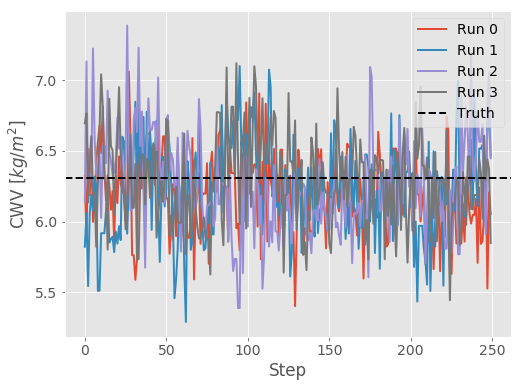

In [133]:
f = plt.figure()
for i in range(4):
    plt.plot(cwv[i,:,0],label= "Run " + str(i), alpha = 1, lw = 2)
plt.gca().axhline(cwv_true, label="Truth", c='k', ls='--', lw = 2) 
#plt.title("MCMC Retrieval")
plt.xlabel("Step")
plt.ylabel("CWV $[kg/m^2]$")
plt.legend()
f.savefig("plots/mcmc_example.pdf")

### Results from 4 Runs

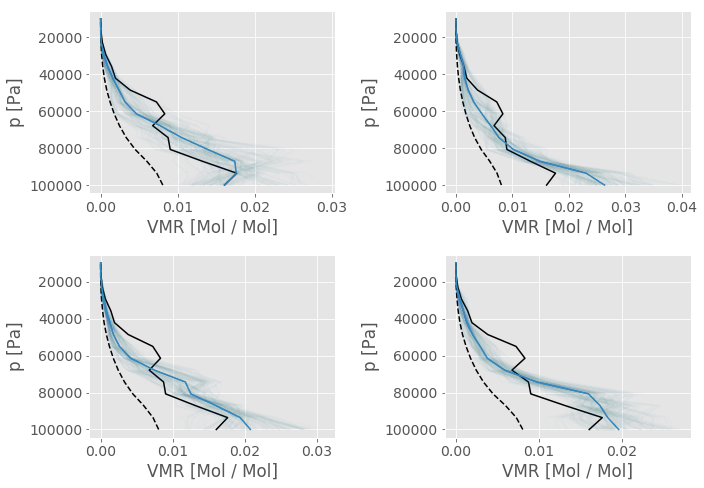

In [109]:
f, axs = plt.subplots(2, 2, figsize = (10, 7))
axs = axs.ravel()
for i in range(4):
    q_mean = np.mean(np.exp(profiles_q[i, :, ::-1]), axis = 0, keepdims = True)
    prof = atms.mmr2vmr(ws, q_mean.ravel(), "h2o")
    axs[i].plot(np.exp(dist.q_log_mean)[::-1] * 28.9 / 18.0,
                ws.p_grid, c = 'k', ls = '--')
    axs[i].plot(q_true, ws.p_grid, c = 'k')
    axs[i].plot(prof, ws.p_grid, c = 'C1')
    for j in range(200):
        k = np.random.randint(0, profiles_q[i, :, :].shape[0])
        prof = atms.mmr2vmr(ws, np.exp(profiles_q[i, k, ::-1]), "h2o")
        axs[i].plot(prof, ws.p_grid, c = 'C1', alpha = 0.01)
    axs[i].invert_yaxis()
    axs[i].set_xlabel("VMR [Mol / Mol]")
    axs[i].set_ylabel("p [Pa]")
f.tight_layout()

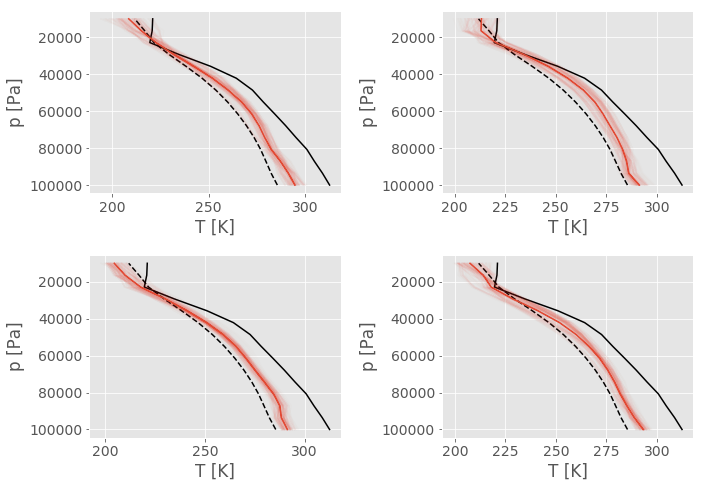

In [110]:
f, axs = plt.subplots(2, 2, figsize = (10, 7))
axs = axs.ravel()
for i in range(4):
    axs[i].plot(dist.t_mean[::-1],
                ws.p_grid, c = 'k', ls = '--')
    axs[i].plot(t_true, ws.p_grid, c = 'k')
    axs[i].plot(np.mean(profiles_t[i, :, :], axis = 0)[::-1],
             ws.p_grid,
             c = 'C0')
    for j in range(200):
        k = np.random.randint(0, profiles_t[i, :, :].shape[0])
        axs[i].plot(profiles_t[i][k, ::-1],
                     ws.p_grid,
                     c = "C0",
                     alpha = 0.01)
    axs[i].invert_yaxis()
    axs[i].set_xlabel("T [K]")
    axs[i].set_ylabel("p [Pa]")
f.tight_layout()